In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import os
import sys
from help_functions import get_top_classes, create_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from focal_loss import BinaryFocalLoss

# Sharing of GPU resources
# tf.config.gpu.set_per_process_memory_growth(True) # TODO didn't work, got error: AttributeError: module 'tensorflow._api.v2.config' has no attribute 'gpu'
# tf.config.threading.set_intra_op_parallelism_threads(10) 
# tf.config.threading.set_inter_op_parallelism_threads(10) 

start = time.time()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


Hyper parameters

In [3]:
RESULTS_FOLDER = 'thesis_experiments/nr_train_layers_512bs_20epochs/3_70layers_algo_20classes_EfficientNetB2'

LOSS_FUNCTION = 'binary_crossentropy'
BATCH_SIZE = 512
EPOCHS = 20

# config: nr_classes, labels, class_weights, basemodel, image_dimension, results_and_checkpoints_folder, data_folder
# i = sys.argv[1]
i = 3
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(i)]
print(config)

{'nr_classes': 20, 'number_trainable_layers': 70, 'class_weights': False, 'augment': False, 'basemodel': 'EfficientNetB2', 'image_dimension': 64, 'results_and_checkpoints_folder': 'thesis_experiments/3_70layers_algo_20classes_EfficientNetB2', 'data_folder': 'data/split_dataframes_heuristic_labels_20220914'}


Loading datasets and augmentation

In [4]:
# ================= LOAD & AUGMENT DATA ================
train_df = pd.read_json(config['data_folder'] + '/train_df.json.bz2', compression='bz2')
top_classes = get_top_classes(config['nr_classes'], train_df)#['Places', 'Culture', 'History', 'Society', 'Nature', 'People', 'Politics', 'Sports', 'Objects', 'Entertainment']
print(f"Top {config['nr_classes']} classes: {top_classes}")

# Only keep rows which have either of the top classes
ids_x_labels = train_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
training_set_x_labels = train_df[ids_x_labels]
training_set_x_labels['labels'] = train_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
train_df = training_set_x_labels.copy()

width, height = config['image_dimension'], config['image_dimension']
target_size = (height, width)
if config['augment'] == True:
    datagen = ImageDataGenerator(rotation_range=40, 
                                width_shift_range=0.2,
                                height_shift_range=0.2, 
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.05) 
else:
    datagen = ImageDataGenerator(validation_split=0.05)

train_generator = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images/', 
        seed=7,
        subset='training',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        batch_size=BATCH_SIZE,
        target_size=target_size)

validation_generator = datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory='/scratch/WIT_Dataset/images/', 
        seed=7,
        subset='validation',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=target_size)

name_id_map = train_generator.class_indices
class_names = len(name_id_map)*[0]
for k in name_id_map.keys():
    class_names[name_id_map[k]] = k

class_indices = train_generator.class_indices
CLASS_LABELS = list(class_indices.keys())
# ======================================================

Found 760000 non-validated image filenames belonging to 42 classes.
Top 20 classes: ['Places' 'Society' 'Culture' 'People' 'Objects' 'History' 'Nature'
 'Events' 'Politics' 'Technology' 'Sports' 'Entertainment' 'Art'
 'Language' 'Architecture' 'Plants' 'Science' 'Music' 'Biology'
 'Landscapes']


<ipython-input-4-d13b7d8b867e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set_x_labels['labels'] = train_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 714849 validated image filenames belonging to 20 classes.
Found 37623 validated image filenames belonging to 20 classes.


In [6]:
# ====================== CREATE MODEL ==================
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def create_model(name):
    if name == 'EfficientNetB0':
        efficient_net = EfficientNetB0(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                           input_shape=(width, height, 3))
    elif name == 'EfficientNetB1':
        efficient_net = EfficientNetB1(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                           input_shape=(width, height, 3))
    elif name == 'EfficientNetB2':
        efficient_net = EfficientNetB2(include_top=False, weights='imagenet', classes=len(CLASS_LABELS),
                                           input_shape=(width, height, 3))

    print(f'\nNumber of layers in basemodel: {len(efficient_net.layers)}')
    # Fine tune from this layer onwards
    # fine_tune_at = round((1 - config['percent_trainable_layers']) * len(efficient_net.layers))
    number_trainable_layers = config['number_trainable_layers']
    fine_tune_at = len(efficient_net.layers) - number_trainable_layers
 
    print(f'Number of trainable layers: {len(efficient_net.layers) - fine_tune_at}\n')
    for layer in efficient_net.layers[:fine_tune_at]:
        layer.trainable = False

    model = Sequential([
        efficient_net,
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(CLASS_LABELS), activation='sigmoid')
    ])

    # Losses:
    #   - binary cross-entropy: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy
    #   - binary focal cross-entropy: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryFocalCrossentropy

    if LOSS_FUNCTION == 'binary_crossentropy':
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'categorical_accuracy'])
    # Binary Focal Cross Entropy
    elif LOSS_FUNCTION == 'binary_focal_crossentropy':
        model.compile(optimizer=tf.keras.optimizers.Adam(),
                    loss=BinaryFocalLoss(gamma=2, from_logits=False),
                    metrics=['accuracy', 'categorical_accuracy'])

    model.summary()
    return model


Number of layers in basemodel: 339
Number of trainable layers: 70

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten_2 (Flatten)          (None, 5632)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               721024    
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 5,722,684
Non-trainable params: 2,769,489
_________________________________________________________________


In [5]:
model = create_model(n_labels=config['nr_classes'], 
                     image_dimension=config['image_dimension'],
                     model_name=config['basemodel'], number_trainable_layers=config['number_trainable_layers'])
model.load_weights(RESULTS_FOLDER + '/checkpoints/cp-0004.ckpt')


Number of layers in basemodel: 339
Number of trainable layers: 70

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 2, 2, 1408)        7768569   
_________________________________________________________________
flatten (Flatten)            (None, 5632)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               721024    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2580      
Total params: 8,492,173
Trainable params: 5,722,684
Non-trainable params: 2,769,489
_________________________________________________________________


Construct dataset that only have ['STEM.Biology', 'Culture.Sports'] or if you want to have more images ['Culture.Biography.Biography*', 'STEM.STEM*']

Train model

In [6]:
# ===================== TRAIN MODEL ==================
# Save model in between epochs
checkpoint_path = config['results_and_checkpoints_folder'] + "/cp-{epoch:04d}.ckpt"
print(checkpoint_path)
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 verbose=1)
history_callback = tf.keras.callbacks.CSVLogger(f"{config['results_and_checkpoints_folder']}/history.csv", 
                                                separator=',', 
                                                append=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           min_delta=0,
                                                           patience=3,
                                                           verbose=0,
                                                           mode='auto',
                                                           restore_best_weights=True)
# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

if config['class_weights'] == True:
    # Calculate class weights: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#calculate_class_weights
    weights = train_df[["labels", "title"]].explode("labels")\
            .groupby("labels").agg("count").reset_index()
    total = weights.title.sum()
    weights['proportion'] = weights.title.apply(lambda r: r/total)
    weights['weight'] = weights.title.apply(lambda r: (1/r)*(total/41)) # 
    # weights['weight'] = weights.page_title.apply(lambda r: np.log((1/r)*(total/2)))
    weights = weights[['labels', 'proportion', 'weight']]
    class_weight={}
    for l in name_id_map.keys():
        w = weights[weights.labels==l].weight.iloc[0]
        class_weight[train_generator.class_indices[l]] = w
    history = model.fit(
    train_generator,
    verbose=2,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[cp_callback, history_callback, early_stopping_callback],
    class_weight=class_weight)

else:
    history = model.fit(
    train_generator,
    verbose=2,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=[cp_callback, history_callback, early_stopping_callback])
# ======================================================

Plot training metrics

In [8]:
# ================= PLOT TRAINING METRICS ==============
def plot_training_metrics():
    "Plot training metrics: loss & accuracy"
    training_metrics = pd.read_csv(config['results_and_checkpoints_folder'] + '/history.csv')

    epochs = training_metrics.shape[0]

    acc = training_metrics.accuracy.values
    loss = training_metrics.loss.values

    val_acc = training_metrics.val_accuracy.values
    val_loss = training_metrics.val_loss.values

    _ = plt.figure(figsize=(12, 4))
    _ = plt.subplot(1, 3, 1)
    _ = plt.plot(range(epochs), acc, label='Training Accuracy')
    _ = plt.plot(range(epochs), val_acc, label='Validation Accuracy')
    _ = plt.legend(loc='lower right')
    _ = plt.title('Training and Validation Accuracy')

    _ = plt.subplot(1, 3, 2)
    _ = plt.plot(range(epochs), loss, label='Training Loss')
    _ = plt.legend(loc='upper right')
    _ = plt.title('Training Loss')

    _ = plt.subplot(1, 3, 3)
    _ = plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
    _ = plt.legend(loc='upper right')
    _ = plt.title('Validation Loss')
    _ = plt.savefig(config['results_and_checkpoints_folder'] + '/training_metrics.png')
# plot_training_metrics()

### To test an already tested model, skip the training and load the weights

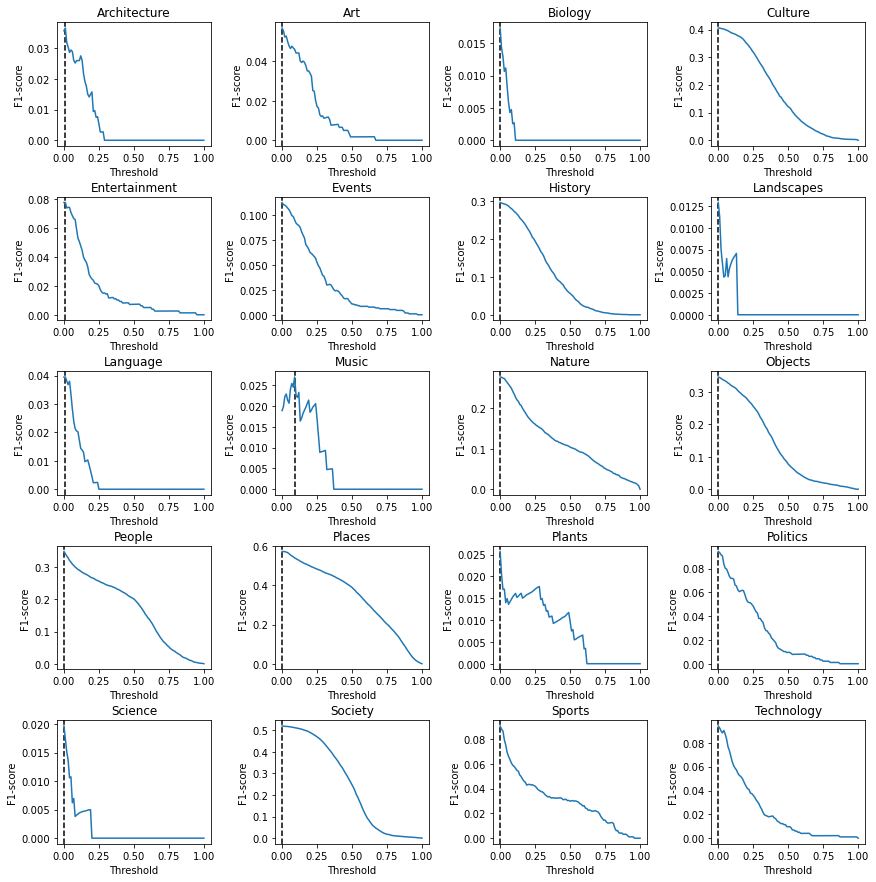

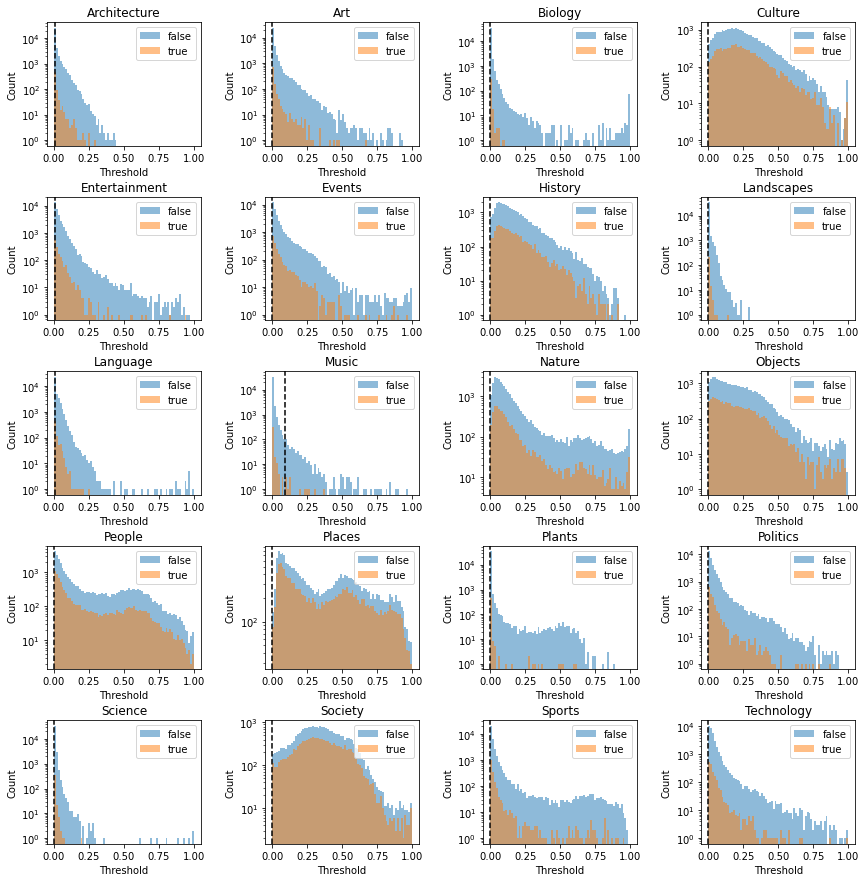

In [6]:
from sklearn.metrics import f1_score

val_predictions = model.predict(validation_generator)

y_true_val = np.zeros(val_predictions.shape)
for row_idx, row in enumerate(validation_generator.classes):
    for idx in row:
        y_true_val[row_idx, idx] = 1

def plot_probs_and_best_threshold(y_true, probs):
    def to_label(probs, threshold):
        return (probs >= threshold) * 1

    thresholds = np.linspace(start=0, stop=1, num=101)
    
    best_thresholds = np.zeros((len(CLASS_LABELS, )))

    # F1-scores per threshold
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    fig.tight_layout(h_pad=3.0, w_pad=3.0)
    for label_idx, ax in zip(range(len(CLASS_LABELS)), axs.flatten()):
        f1_scores = [f1_score(y_true=y_true[:, label_idx], y_pred=to_label(probs[:, label_idx], t)) for t in thresholds]
        best_thresholds[label_idx] = thresholds[np.argmax(f1_scores)]
        ax.axvline(x=best_thresholds[label_idx], color='k', linestyle='--')
        ax.plot(thresholds, f1_scores)
        ax.set_title(CLASS_LABELS[label_idx])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1-score')

    # Prediction probabilities for ground-truth TRUE and FALSE
    fig, axs = plt.subplots(5, 4, figsize=(12, 12))
    fig.tight_layout(h_pad=3.0, w_pad=3.0)
    bins = np.linspace(0, 1, 75)
    for label_idx, ax in zip(range(len(CLASS_LABELS)), axs.flatten()):
        ax.hist(probs[y_true[:, label_idx] == 0][:, label_idx], bins, alpha=0.5, label='false', log=True)
        ax.hist(probs[y_true[:, label_idx] == 1][:, label_idx], bins, alpha=0.5, label='true', log=True)
        ax.axvline(x=best_thresholds[label_idx], color='k', linestyle='--')
        ax.legend(loc='upper right')
        ax.set_title(CLASS_LABELS[label_idx])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('Count')
plot_probs_and_best_threshold(y_true=y_true_val, probs=val_predictions)

Found 760000 non-validated image filenames belonging to 42 classes.


<ipython-input-7-041437e6f751>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 39614 validated image filenames belonging to 20 classes.
1238/1238 - 120s


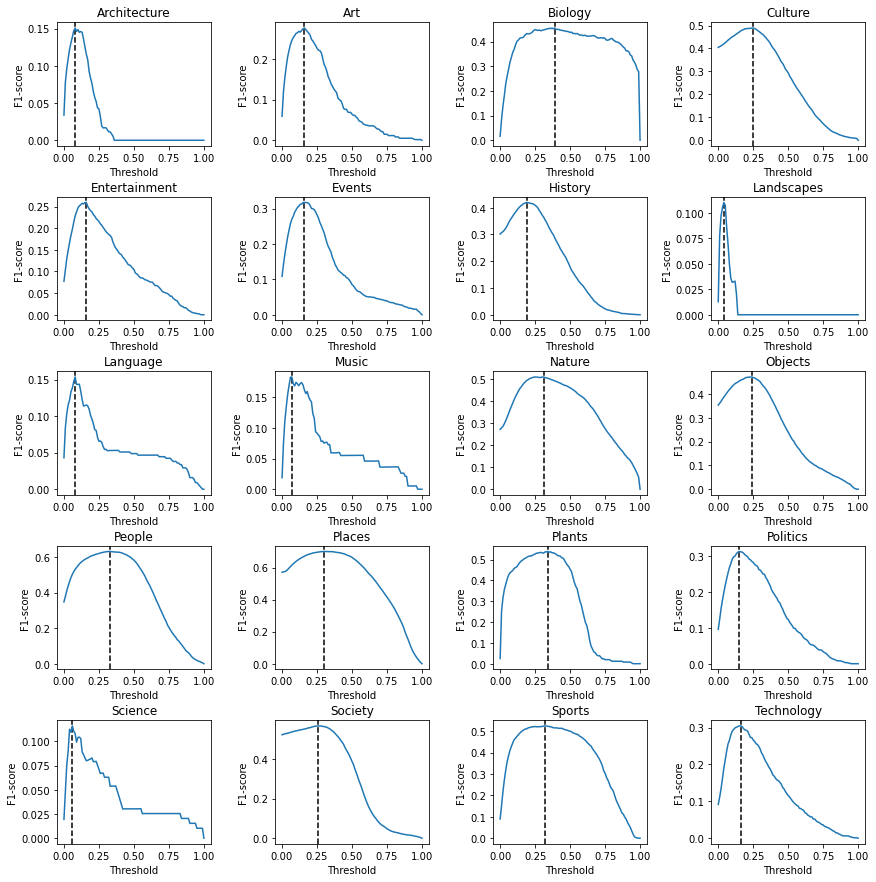

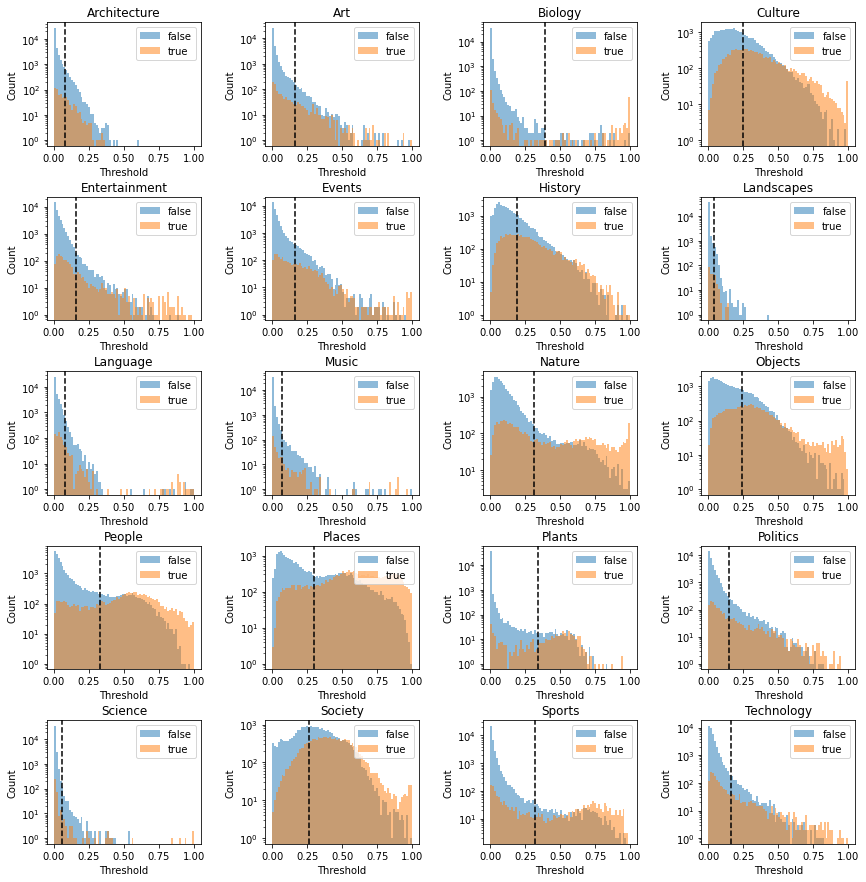

In [7]:
# ====================== LOAD TEST SET =================
test_df = pd.read_json(config['data_folder'] + '/test_df.json.bz2', compression='bz2')
train_df = pd.read_json(config['data_folder'] + '/train_df.json.bz2', compression='bz2')
top_classes = get_top_classes(config['nr_classes'], train_df) # OBS: are they always the same as top classes of train_df? In the 10-case yes.
# Only keep rows which have either of the top classes
ids_x_labels = test_df.labels.apply(lambda classes_list: any([True for a_class in top_classes if a_class in classes_list]))
test_set_x_labels = test_df[ids_x_labels]
test_set_x_labels['labels'] = test_df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])
test_df = test_set_x_labels.copy()

datagen = ImageDataGenerator() 
test = datagen.flow_from_dataframe(
        dataframe=test_df, 
        directory='/scratch/WIT_Dataset/images',
        color_mode='rgb',
        x_col='url', 
        y_col='labels', 
        class_mode='categorical', 
        target_size=(config['image_dimension'], config['image_dimension']),
        shuffle=False
        )

N_LABELS = len(test.class_indices)
# ======================================================

# =============== PREDICT ON TEST SET ==================

test_predictions = model.predict(test, verbose=2)
y_true_test = np.zeros(test_predictions.shape)
for row_idx, row in enumerate(test.classes):
    for idx in row:
        y_true_test[row_idx, idx] = 1
# ======================================================

plot_probs_and_best_threshold(y_true=y_true_test, probs=test_predictions)

Calculating the optimal thresholds for the validation set

Same thing for the test set

#### Visualize images from these labels

<ipython-input-185-be55bc3b022b>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)


UnicodeEncodeError: 'latin-1' codec can't encode character '\u0117' in position 49: ordinal not in range(256)

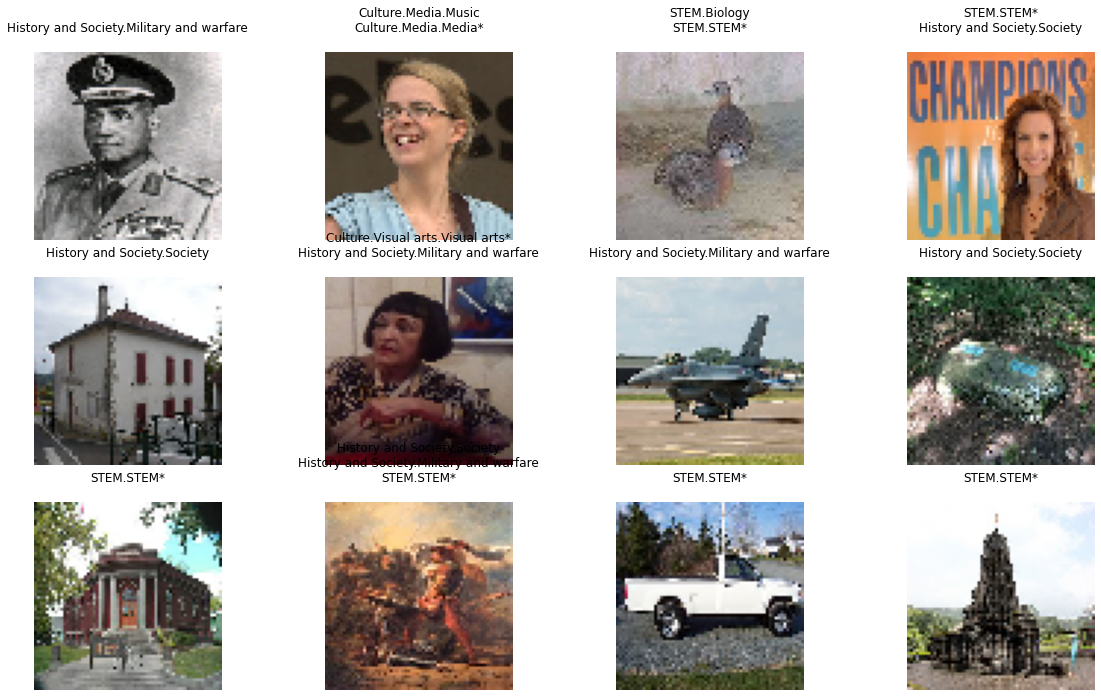

In [185]:
from tensorflow.keras.preprocessing.image import load_img

plt.figure(figsize=(20, 20))
IMAGE_DIMENSION = 64
columns = 4
rows = 4
random_indices = np.random.randint(low=0, high=1e5, size=(rows,columns))
for i, idx in enumerate(random_indices.flatten()):
    path = '/scratch/WIT_Dataset/images/' + training_set_x_labels.iloc[idx, :].image_path
    img = load_img(path, target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION))
    plt.subplot(len(random_indices.flatten()) / columns + 1, columns, i + 1)
    plt.imshow(img)
    plt.axis('off')
    title = ''.join([label + '\n' for label in training_set_x_labels.iloc[idx, :].labels])
    plt.title(title)
plt.suptitle('Some images and their ground truths')